In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
#import deepxde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


## 1D Poisson Dirichlet

In [2]:
from keras.models import Sequential
from keras.layers import Dense

M = 100
Rm = 2
d=1

weight = np.zeros((M,d))
biases = np.zeros((M,1))

for i in range(M):
    for j in range(d):
        weight[i][j]= np.random.uniform(low=-Rm, high=Rm)
    biases[i] = np.random.uniform(low=-0.0005, high=0.0005)

def phi(x):
    #out = np.zeros((np.shape(x)[0],M))
    bias = np.repeat(biases, np.shape(x)[1], axis = -1)
    out = np.sin(weight@x + bias)
    return out

xx = np.zeros((1,10))

print(np.shape(phi(xx)))
print(np.shape(weight))
print(np.shape(biases))


(100, 10)
(100, 1)
(100, 1)


In [3]:
train = np.array([np.linspace(-1, 1, 20)])
test = np.array([np.linspace(-1, 1, 7)])
print(np.shape(train))

def func(x):
    return np.sin(np.pi * x)
    
y_train = func(train).T

y_test = func(test).T

(1, 20)


In [4]:
k_init = tf.keras.initializers.RandomUniform(minval=-Rm, maxval=Rm)
b_init = tf.keras.initializers.RandomUniform(minval=-0.0005, maxval=0.0005)
def custom_activation(x):
    return tf.sin(x)

model = Sequential()
#layer1 = Dense(M, activation=custom_activation)

model.add(Dense(M, activation=custom_activation, input_dim=d, kernel_initializer=k_init,bias_initializer=b_init, trainable=False))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', 
                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),'accuracy'])

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history = model.fit(train.T, y_train, validation_data = (test.T,y_test), epochs=2000, batch_size=64, callbacks=[callback])

Epoch 1/2000
1/1 [==============================] - 1s 512ms/step - loss: 0.1608 - mean_absolute_error: 0.3524 - accuracy: 0.0000e+00 - val_loss: 0.2265 - val_mean_absolute_error: 0.4012 - val_accuracy: 0.1429
Epoch 2/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.1580 - mean_absolute_error: 0.3511 - accuracy: 0.0000e+00 - val_loss: 0.2195 - val_mean_absolute_error: 0.3995 - val_accuracy: 0.1429
Epoch 3/2000
1/1 [==============================] - 0s 32ms/step - loss: 0.1558 - mean_absolute_error: 0.3496 - accuracy: 0.0000e+00 - val_loss: 0.2144 - val_mean_absolute_error: 0.3973 - val_accuracy: 0.1429
Epoch 4/2000
1/1 [==============================] - 0s 30ms/step - loss: 0.1537 - mean_absolute_error: 0.3477 - accuracy: 0.0000e+00 - val_loss: 0.2108 - val_mean_absolute_error: 0.3945 - val_accuracy: 0.1429
Epoch 5/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.1517 - mean_absolute_error: 0.3455 - accuracy: 0.0000e+00 - val_loss: 0.2081 - val_mean_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 301
Trainable params: 101
Non-trainable params: 200
_________________________________________________________________
None


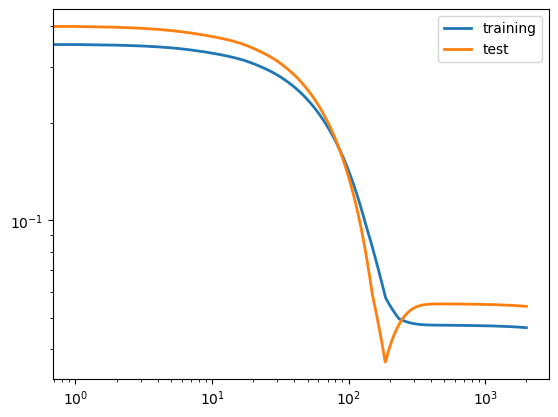

In [6]:
print(model.summary())
bc     = history.history['mean_absolute_error']
bc_val     = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2, label='training')
plt.loglog(range(np.shape(bc_val)[0]),bc_val, linewidth=2, label='test')
plt.legend()
plt.show()

4/4 [==============================] - 0s 2ms/step


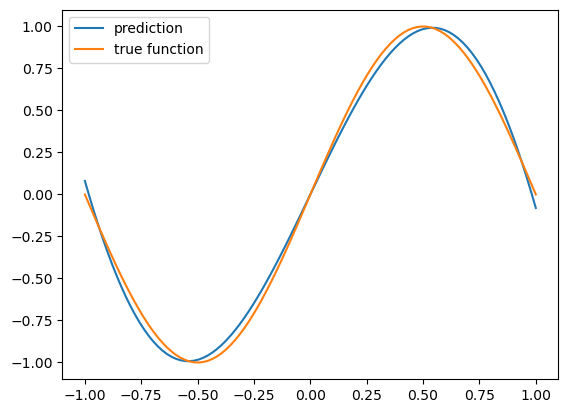

In [7]:
val = np.linspace(-1, 1, 100)

y_pred = model.predict(val)
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.legend()

### PINN random

In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from keras.models import Sequential
from keras.layers import Dense

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [7]:
pi = np.pi

def func(x):
    return np.sin(np.pi * x)
    #return np.sin(3*pi*x + 3*pi/20)*np.cos(2*pi*x + pi/10) + 2


def fun_u_b(x):
    n = x.shape[0]

    return tf.zeros((n,1))
    #u_low = [func(-1.)]
    #u_up = [func(1.)]
    #return tf.constant([u_low, u_up])

# Define residual of the PDE
def fun_r(x, u, u_x, u_xx):
    return -u_xx - np.pi ** 2 * tf.sin(np.pi * x)  # residuo seno
    #return -u_xx - 13*pi**2*tf.sin(3*pi*x + 3*pi/20)*tf.cos(2*pi*x + pi/10) - 12*pi**2*tf.cos(3*pi*x + 3*pi/20)*tf.sin(2*pi*x + pi/10)

In [8]:
# Set number of data points
N_b = 2
N_r = 20

# Set boundary
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([xmin])
# Upper bounds
ub = tf.constant([xmax])

# Set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data
'''x_b = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5)
X_b = tf.concat([x_b], axis=1)'''
x_b = tf.constant([xmin, xmax])
# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b)

x_b = tf.constant(u_b)
# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0])
'''x_r = np.linspace(xmin, xmax, N_r, dtype='float32')
xx = []
for i in range(N_r):
    xx.append([x_r[i]])
x_r = tf.constant(xx)'''
X_r = tf.concat([x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [x_b]
u_data = [u_b]

In [24]:
d = 1
Rm = 4
M = 50
k_init = tf.keras.initializers.RandomUniform(minval=-Rm, maxval=Rm)
b_init = tf.keras.initializers.RandomUniform(minval=-0.0005, maxval=0.0005)
def custom_activation(x):
    return tf.sin(x)

model2 = Sequential()
#layer1 = Dense(M, activation=custom_activation)

model2.add(Dense(M, activation=custom_activation, input_dim=d, kernel_initializer=k_init,bias_initializer=b_init, trainable=False))
model2.add(Dense(1))

def get_r(model2, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x = X_r[:, 0:1]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)

        # Determine residual 
        u = model2(tf.stack([x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(x, u, u_x, u_xx)

def compute_loss(model2, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model2, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    #u_da = tf.cast(u_data, tf.float32)
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model2(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

def get_grad(model2, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model2.trainable_variables)
        loss = compute_loss(model2, X_r, X_data, u_data)

    g = tape.gradient(loss, model2.trainable_variables)
    del tape

    return loss, g

'''model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', 
                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),'accuracy'])'''

'model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=\'adam\', \n                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),\'accuracy\'])'

In [25]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model2, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model2.trainable_variables))
    
    return loss

# Number of training epochs
N = 50000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.86417694e+02
It 00050: loss = 3.58078241e-01
It 00100: loss = 1.54037410e-02
It 00150: loss = 1.24142766e-02
It 00200: loss = 1.18834022e-02
It 00250: loss = 1.13129318e-02
It 00300: loss = 1.07062627e-02
It 00350: loss = 1.00752469e-02
It 00400: loss = 9.43029765e-03
It 00450: loss = 8.78051855e-03
It 00500: loss = 8.13364051e-03
It 00550: loss = 7.49638584e-03
It 00600: loss = 6.87458087e-03
It 00650: loss = 6.27304241e-03
It 00700: loss = 5.69589995e-03
It 00750: loss = 5.14628785e-03
It 00800: loss = 4.62669553e-03
It 00850: loss = 4.13887948e-03
It 00900: loss = 3.68399685e-03
It 00950: loss = 3.26257944e-03
It 01000: loss = 2.87472410e-03
It 01050: loss = 2.83085252e-03
It 01100: loss = 2.79282336e-03
It 01150: loss = 2.75382330e-03
It 01200: loss = 2.71396921e-03
It 01250: loss = 2.67328438e-03
It 01300: loss = 2.63178349e-03
It 01350: loss = 2.58951122e-03
It 01400: loss = 2.54646153e-03
It 01450: loss = 2.50276388e-03
It 01500: loss = 2.45839730e-03
It 01550

4/4 [==============================] - 0s 1ms/step


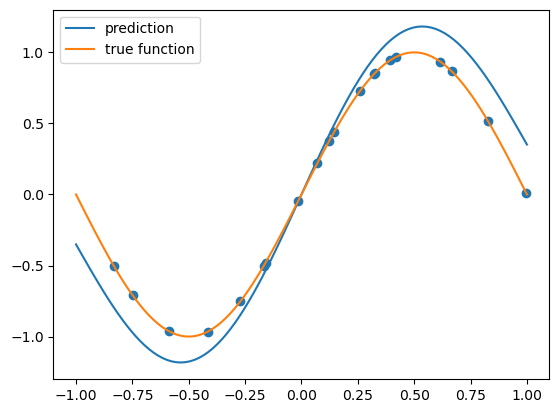

In [26]:
y_r = func(x_r)

val = np.linspace(xmin, xmax, 100)

y_pred = model2.predict(val)
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.scatter(x_r, y_r)
plt.legend()

### Deepxde random

In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
#import deepxde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    # Use torch.sin for backend pytorch
    # return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)
    # Use paddle.sin for backend paddle
    # return -dy_xx - np.pi ** 2 * paddle.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)


In [8]:
bcs = bc if isinstance(bc, (list, tuple)) else [bc]
for i, b in enumerate(bcs):
    print(i, b)

0 <deepxde.icbc.boundary_conditions.DirichletBC object at 0x00000214A8F32850>


In [3]:
M = 800
layer_size = [1] + [M]  + [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"

net = dde.nn.FNN_copy(layer_size, activation, initializer, Rm=10)

In [5]:
np.cumsum([0] + [7])

array([0, 7], dtype=int32)

In [4]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=100000)

Compiling model...
'compile' took 0.001319 s

Training model...



c:\Users\Marco\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


[2]
[0, 2]
[<tf.Tensor 'sub:0' shape=(20, 1) dtype=float32>]
[2]
[0, 2]
[<tf.Tensor 'sub:0' shape=(20, 1) dtype=float32>]
[2]
[0, 2]
[<tf.Tensor 'sub:0' shape=(102, 1) dtype=float32>]
Step      Train loss              Test loss               Test metric   
0         [4.35e+01, 1.32e-02]    [4.92e+01, 1.32e-02]    [9.77e-01]    
1000      [4.34e+01, 4.10e-02]    [4.90e+01, 4.10e-02]    [1.04e+00]    
2000      [4.27e+01, 1.12e-05]    [4.83e+01, 1.12e-05]    [9.90e-01]    
3000      [4.22e+01, 1.13e-05]    [4.77e+01, 1.13e-05]    [9.84e-01]    
4000      [4.15e+01, 7.12e-04]    [4.69e+01, 7.12e-04]    [9.82e-01]    
5000      [4.06e+01, 9.75e-06]    [4.59e+01, 9.75e-06]    [9.65e-01]    
6000      [4.00e+01, 6.02e-02]    [4.53e+01, 6.02e-02]    [9.11e-01]    
7000      [3.91e+01, 9.64e-06]    [4.42e+01, 9.64e-06]    [9.46e-01]    
8000      [3.81e+01, 3.63e-04]    [4.30e+01, 3.63e-04]    [9.33e-01]    
9000      [3.77e+01, 8.50e+00]    [4.26e+01, 8.50e+00]    [1.59e+00]    
10000     [3.

Saving loss history to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\loss.dat ...
Saving training data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\train.dat ...
Saving test data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\test.dat ...


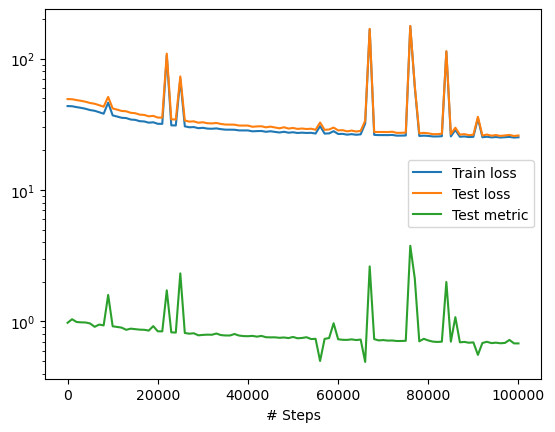

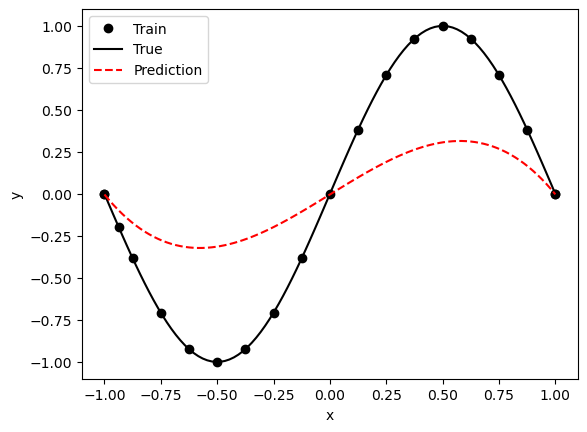

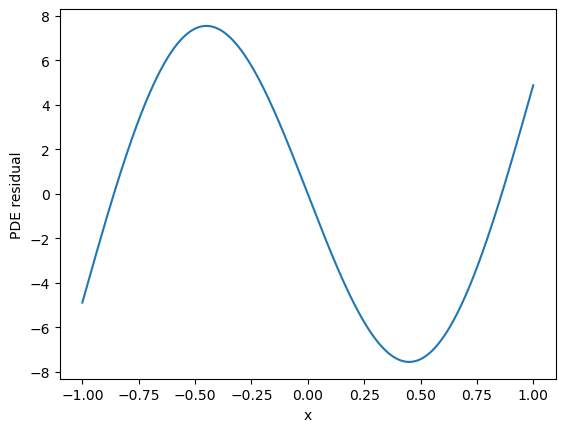

In [5]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

## 2D Helmotz

In [ ]:
M = 300
Rm = 2
dim = 2
weights = np.zeros((M, dim))
biases = np.zeros((M, dim))

for i in range(M):
    for j in range(dim):
        weights[i, j] = np.random.uniform(low=-Rm, high=Rm)
        biases[i, j] = np.random.uniform(low=-0.0005, high=0.0005)

def phi(x):
    out = np.zeros((np.shape(x)[0],M, dim))
    for j in range(np.shape(x)[0]):
        for i in range(M):
            for k in range(dim):
                out[j][i][k] = tf.sin(weights[i][k]*x[j][k] + biases[i][k])
    return out

xx = np.zeros((4,2))

print(np.shape(phi(xx)))
print(np.shape(phi(xx).reshape(4, M*dim)))

(4, 300, 2)
(4, 600)


In [ ]:
model2 = Sequential()
model2.add(Dense(1, input_dim=M*dim))

model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', 
                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),'accuracy'])

In [ ]:
x_train = np.linspace(0, 1, 20)
x_test = np.linspace(0, 1, 7)

train = np.zeros((400, dim))
test = np.zeros((49, dim))
k = 0
k_test = 0
for i in range(20):
    for j in range(20):
        train[k][0] = x_train[i]
        train[k][1] = x_train[j]
        if i < 7 and j < 7:
            test[k_test][0] = x_test[i]
            test[k_test][1] = x_test[j]
            k_test = k_test + 1
        k = k + 1

In [ ]:
print(np.shape(train))
print(np.shape(phi(train)))

(400, 2)
(400, 100, 2)


In [ ]:
phi_train = phi(train)
phi_test = phi(test)

phi_train = phi_train.reshape(np.shape(phi_train)[0], M*dim)
phi_test = phi_test.reshape(np.shape(phi_test)[0], M*dim)

def func(x):
    k0 = 2*np.pi*dim
    return tf.sin(k0 * x[:, 0:1]) * tf.sin(k0 * x[:, 1:2])

y_train = func(train)
y_test = func(test)

In [ ]:
history2 = model2.fit(phi_train, y_train, validation_data = (phi_test,y_test), epochs=1500, batch_size=64)

Epoch 1/1500
7/7 [==============================] - 1s 35ms/step - loss: 0.3212 - mean_absolute_error: 0.4505 - accuracy: 0.0925 - val_loss: 0.2506 - val_mean_absolute_error: 0.3884 - val_accuracy: 0.2653
Epoch 2/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2572 - mean_absolute_error: 0.3984 - accuracy: 0.0975 - val_loss: 0.2174 - val_mean_absolute_error: 0.3537 - val_accuracy: 0.2653
Epoch 3/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2422 - mean_absolute_error: 0.3926 - accuracy: 0.0975 - val_loss: 0.1996 - val_mean_absolute_error: 0.3232 - val_accuracy: 0.2653
Epoch 4/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2360 - mean_absolute_error: 0.3718 - accuracy: 0.0975 - val_loss: 0.1935 - val_mean_absolute_error: 0.3033 - val_accuracy: 0.2653
Epoch 5/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2319 - mean_absolute_error: 0.3850 - accuracy: 0.0975 - val_loss: 0.1860 - val_mean_absolute_error: 0.2728 - 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 601       
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
None


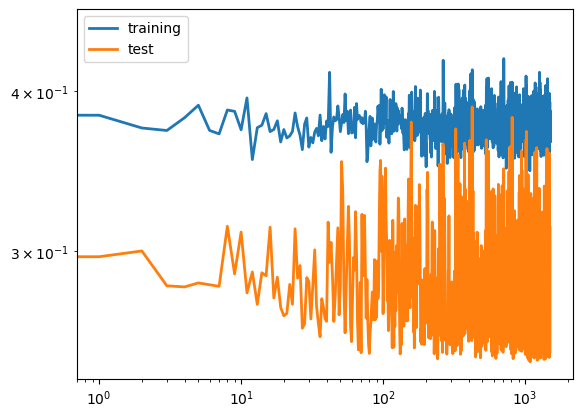

In [ ]:
print(model2.summary())
bc     = history2.history['mean_absolute_error']
bc_val     = history2.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,label='training')
plt.loglog(range(np.shape(bc_val)[0]),bc_val, linewidth=2,label='test')
plt.legend()
plt.show()

In [ ]:
x_val = np.linspace(0, 1, 10)
val = np.zeros((100,2))
k = 0
for i in range(10):
    for j in range(10):
        val[k][0] = x_val[i]
        val[k][1] = x_val[j]
        k = k + 1
phi_val = phi(val)
y_pred = model.predict(phi_val.reshape(np.shape(phi_val)[0], M*dim))
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.legend()

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_7/dense_6/MatMul' defined at (most recent call last):
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Marco\AppData\Local\Temp\ipykernel_12220\4249827134.py", line 10, in <module>
      y_pred = model.predict(phi_val.reshape(np.shape(phi_val)[0], M*dim))
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_7/dense_6/MatMul'
Matrix size-incompatible: In[0]: [32,600], In[1]: [100,1]
	 [[{{node sequential_7/dense_6/MatMul}}]] [Op:__inference_predict_function_14074158]